In [1]:
# imports
import csv
import math
import random
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import NearestNeighbors
import sklearn.model_selection as ms
from sklearn.metrics import f1_score
from dateutil.parser import parse
from datetime import datetime
import statsmodels.api as sm
from scipy import stats
import fairlearn.moments as moments
import fairlearn.classred as red
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from statistics import mean, median, stdev
from matplotlib.ticker import FuncFormatter

# Part 1: Data Preparation

We'll begin by importing the data and doing some basic information extraction and cleaning. 
This helps prepare our dataset for model building later on.

The data file, whose contents are described in the provided file _Data Dictionary.xlsx_, is:

* `train.csv` - data on auto-loans, in comma-separated value (CSV) format

## Step 1.1 Importing CSV Data

The first task will be to import tabular data.

In [2]:
# load data
train_x = pd.read_csv("../Credit-Scoring/train.csv")
train_x = train_x.iloc[0:200000]

In [3]:
# observe what data looks like
train_x.head(10)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-1990,Self employed,...,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-1988,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-1989,Salaried,...,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,490213,53713,61973,89.56,67,22807,45,1497,15-11-1991,Self employed,...,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,510980,52603,61300,86.95,67,22807,45,1492,01-06-1968,Salaried,...,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


In [4]:
# Identify number of missing values in different columns
train_x.isnull().sum()

UNIQUEID                                  0
DISBURSED_AMOUNT                          0
ASSET_COST                                0
LTV                                       0
BRANCH_ID                                 0
SUPPLIER_ID                               0
MANUFACTURER_ID                           0
CURRENT_PINCODE_ID                        0
DATE_OF_BIRTH                             0
EMPLOYMENT_TYPE                        6749
DISBURSAL_DATE                            0
STATE_ID                                  0
EMPLOYEE_CODE_ID                          0
MOBILENO_AVL_FLAG                         0
AADHAR_FLAG                               0
PAN_FLAG                                  0
VOTERID_FLAG                              0
DRIVING_FLAG                              0
PASSPORT_FLAG                             0
PERFORM_CNS_SCORE                         0
PERFORM_CNS_SCORE_DESCRIPTION             0
PRI_NO_OF_ACCTS                           0
PRI_ACTIVE_ACCTS                

## Part 1.2 Handling Missing Data

Since our only missing data __'EMPLOYMENT_TYPE'__ is categorical, we assign a unique 'missing' label to rows missing that value.

In [5]:
# fill missing categorical variables with new label 'Missing'
categorical_missing_vars = ['EMPLOYMENT_TYPE']
for category in categorical_missing_vars:
    train_x[category] = train_x[category].fillna('Missing')

## Part 1.3 Wrangling Zip-Codes

Because there are so many values for __'CURRENT_PINCODE_ID'__, to ensure that enough samples belong to each category, we will bin them by dropping the first 2 digits, leaving only the area code.

In [6]:
train_x['CURRENT_PINCODE_ID'] = train_x['CURRENT_PINCODE_ID'].apply(lambda x: x//100)
train_x[['CURRENT_PINCODE_ID']].head()

,CURRENT_PINCODE_ID
0,14
1,15
2,14
3,15
4,14


## Part 1.4 Converting Birthdays to Age

To make __DATE_OF_BIRTH__ a useable numeric feature, we will convert birthdays to age in years

In [7]:
def age(x):
    birthday = parse(x)
    now = datetime.now()
    return (now - birthday).days // 365
train_x['DATE_OF_BIRTH'] = train_x['DATE_OF_BIRTH'].apply(age)
train_x['DATE_OF_BIRTH'].describe()

count    200000.000000
mean         34.804120
std           9.840709
min          18.000000
25%          27.000000
50%          33.000000
75%          42.000000
max          65.000000
Name: DATE_OF_BIRTH, dtype: float64

## Part 1.5 Parsing Months from Months & Years Strings

__AVERAGE_ACCT_AGE__ and __CREDIT_HISTORY_LENGTH__ were both in the form _4yrs 8mon to number_
We parse these strings and convert them to numeric months

In [8]:
toParse = ['AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH']

def monthsFromString(string):
    split = string.split('yrs')
    yearsToMonths = int(split[0]) * 12
    months = int(split[1].split(' ')[1].split('mon')[0])
    return yearsToMonths + months

for field in toParse:
    train_x[field] = train_x[field].apply(monthsFromString)

train_x['AVERAGE_ACCT_AGE'].describe()

count    200000.000000
mean          8.913920
std          15.152675
min           0.000000
25%           0.000000
50%           0.000000
75%          13.000000
max         369.000000
Name: AVERAGE_ACCT_AGE, dtype: float64

## Part 1.6 Converting Categorical Variables to One-hot Encodings

Categorical variables will be converted to one-hot encodings to allow for regression. 
The following were one-hot encoded:

__['BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'STATE_ID', 'EMPLOYMENT_TYPE', 'STATE_ID', 'PERFORM_CNS_SCORE_DESCRIPTION']__

Some categorical variables were already one-hot encodeded:

__['AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG']__

**Note: Although we would typically take this step, for computational efficiency we are excluding categorical variables for now**

In [9]:
# replace non-binary categorical variables with one-hot encodings
categorical_vars = ['BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'STATE_ID', 'EMPLOYMENT_TYPE', 'PERFORM_CNS_SCORE_DESCRIPTION', 'CURRENT_PINCODE_ID']
# for category in categorical_vars:
#     train_x[category] = train_x[category].astype(str)
#     train_x = pd.concat([train_x, pd.get_dummies(train_x[category], drop_first=True)], axis=1)
#     train_x.drop([category], axis=1, inplace=True)
train_x.shape
train_x = train_x.drop(columns=categorical_vars)



## Part 1.7 Non-Predictive Attributes Dropped

We finally drop columns that won't be predictive or take on only one value, including:

__['DISBURSAL_DATE', 'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'UNIQUEID', 'EMPLOYEE_CODE_ID']__

In [10]:
cols_to_drop = ['DISBURSAL_DATE', 'MOBILENO_AVL_FLAG', 'UNIQUEID', 'EMPLOYEE_CODE_ID']
train_x = train_x.drop(columns = cols_to_drop)

## Part 1.8 Adding a Protected Attribute

As there were no protected attributes in the dataset, we synthetically generate biased __GENDER__ values.

In [11]:
def biasedGender(row):
    # 1 is female, 0 is male
    # 80% chance of 1 if default, 43% chance of 1 otherwise
    if row.LOAN_DEFAULT == 1:
        if random.randint(1, 101) > 80:
            return 0
        else:
            return 1
    else:
        if random.randint(1, 101) > 43:
            return 0
        else:
            return 1

train_x['IS_FEMALE'] = train_x.apply(biasedGender, axis = 1)
train_x[['IS_FEMALE']].head()

,IS_FEMALE
0,0
1,0
2,1
3,1
4,1


## 1.9 Making it an Alternative Credit Score

By adding mock transaction data, we show how a player in the financial system with data 
on users' transactions could improve their prediction accuracy with regards to default rates.

We will model transaction data using RFM--Recency, Frequency, and Monetary Value--which is a popular method for measuring customer value.

In particular, we'll create mock data for (1) whether or not someone was late on last month's payment, (2) how frequently they make late payments, and (3) the average amount of money in those payments

In [12]:
def biasedRecency(row):
    # 80% chance of 1 if default, 43% chance of 1 otherwise
    if row.LOAN_DEFAULT == 1:
        if random.randint(1, 101) > 80:
            return 0
        else:
            return 1
    else:
        if random.randint(1, 101) > 43:
            return 0
        else:
            return 1
        
def biasedFrequency(row):
    if row.LOAN_DEFAULT == 1:
        maxFreq = 0
        for i in range(5):
            maxFreq = max(maxFreq, random.uniform(0, 0.25))
        return maxFreq
    else:
        return random.uniform(0, 0.25)
    
def monetaryValue(row):
    return random.paretovariate(.1)*1000

train_x['RECENCY'] = train_x.apply(biasedRecency, axis = 1)
train_x['FREQUENCY'] = train_x.apply(biasedFrequency, axis = 1)
train_x['MONETARY_VALUE'] = train_x.apply(monetaryValue, axis = 1)

## 1.10 Feature Selection

We want to include only features that strongly correlate with loan default.
We can identify them using Pearson Correlation, and retain only features whose correlation is above a certain threshold. 

We also remove features that strongly correlate with each other, as well as those with low p-values.

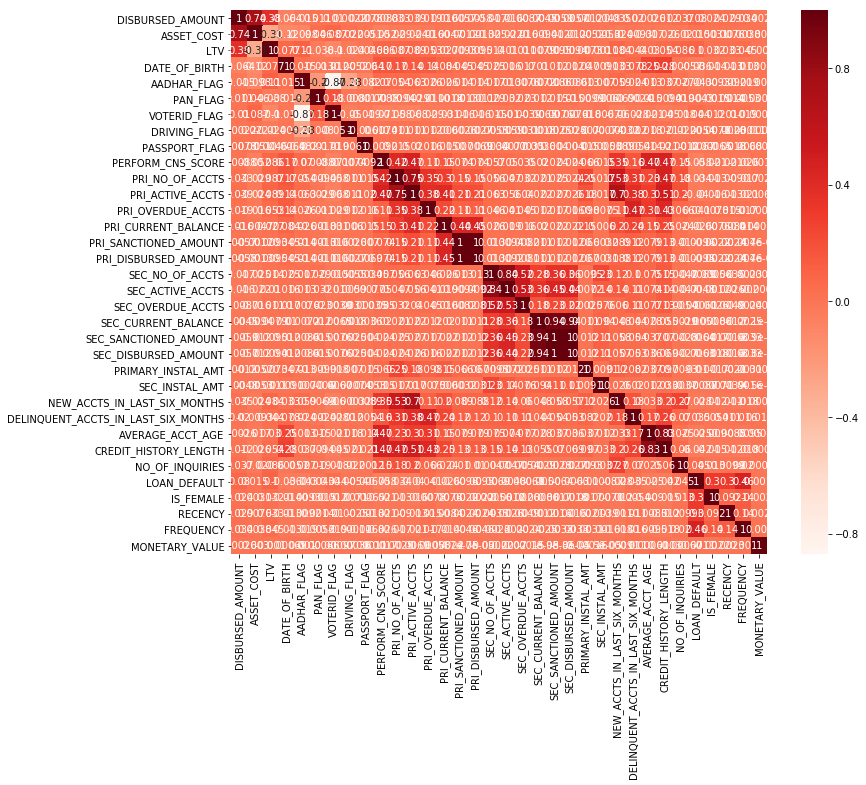

In [13]:
plt.figure(figsize=(12,10))
cor = train_x.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [14]:
cor_target = abs(cor["LOAN_DEFAULT"])
relevant_features = cor_target[cor_target>0.05]
relevant_features_list = list(relevant_features.index)
print(relevant_features)
train_x = train_x[relevant_features_list]
for relevant_feature in relevant_features_list:
    for relevant_feature2 in relevant_features_list:
        if relevant_feature != relevant_feature2:
            corr = train_x[[relevant_feature, relevant_feature2]].corr()[relevant_feature][relevant_feature2]
            if corr > 0.5:
                print(f'Feature 1:{relevant_feature}, Feature 2:{relevant_feature2}, Correlation:{corr}')

DISBURSED_AMOUNT     0.080363
LTV                  0.099636
PERFORM_CNS_SCORE    0.058127
LOAN_DEFAULT         1.000000
IS_FEMALE            0.299780
RECENCY              0.300434
FREQUENCY            0.462433
Name: LOAN_DEFAULT, dtype: float64


In [15]:
# remove features that strongly correlate with one another
# correlated = ['PERFORM_CNS_SCORE', 'CREDIT_HISTORY_LENGTH']
correlated = []
train_x = train_x.drop(columns=correlated)

In [16]:
# move target to a separate column, and drop it from x variables
train_y = train_x['LOAN_DEFAULT']
train_x = train_x.drop(columns="LOAN_DEFAULT")

In [18]:
train_y.describe()

count    200000.000000
mean          0.215185
std           0.410952
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: LOAN_DEFAULT, dtype: float64

In [19]:
# calculate p-values of remaining features
X = sm.add_constant(train_x)
model = sm.Logit(train_y, X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.310751
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           LOAN_DEFAULT   No. Observations:               200000
Model:                          Logit   Df Residuals:                   199993
Method:                           MLE   Df Model:                            6
Date:                Mon, 05 Aug 2019   Pseudo R-squ.:                  0.4033
Time:                        01:44:53   Log-Likelihood:                -62150.
converged:                       True   LL-Null:                   -1.0415e+05
                                        LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -9.6994      0.067   -144.014      0.000      -9.831      -9.567
DISBURSED_AMOUNT   9.703e-06   6.04e-07     16.053      0.000    8.52e-06    1.09e-05
LTV                   0.0205      0.001     28.929      0.000       0.019       0.022
PERFORM_CNS_SCORE    -0.0005   2.16e-05    -21.781      0.000      -0.001      -0.000
IS_FEMALE             1.6410      0.015    105.910      0.000       1.611       1.671
RECENCY               1.6551      0.015    106.852      0.000       1.625       1.685
FREQUENCY            25.1169      0.161    156.458      0.000      24.802      25.431
=====================================================================================
"""

In [20]:
# remove columns with p-values greater than 0.05
lowPValueColumns = []
train_x = train_x.drop(columns=lowPValueColumns)

In [21]:
# visualize prepared data
print(train_x.shape)
train_x.head(10)

(200000, 6)


,DISBURSED_AMOUNT,LTV,PERFORM_CNS_SCORE,IS_FEMALE,RECENCY,FREQUENCY
0,50578,89.55,0,0,1,0.194863
1,47145,73.23,598,0,1,0.212492
2,53278,89.63,0,1,1,0.187645
3,57513,88.48,305,1,1,0.128365
4,52378,88.39,0,1,0,0.207639
5,54513,89.66,825,0,0,0.243656
6,46349,76.42,0,1,0,0.005168
7,43894,71.89,17,0,1,0.092764
8,53713,89.56,718,1,1,0.081940
9,52603,86.95,818,0,1,0.198012


# Part 2: Unfair Model Building



## 2.1 Train/Test Split

We choose an 80-20 Train-Test split, randomly done. We also create data frames without gender, so that we can train models that don't explicitly use gender as a predictor of default.

In [22]:
# train/test split
X_train, X_test, y_train, y_test = ms.train_test_split(train_x, train_y, test_size=0.2, random_state = 195)
print(X_train.shape)
print(X_test.shape)
X_train_no_gender = X_train.drop(columns=['IS_FEMALE'])
X_test_no_gender = X_test.drop(columns=['IS_FEMALE'])

(160000, 6)
(40000, 6)


## 2.2 Applying Scaling

Scaling variables is used to normalize values, and makes interpreting feature importance easier

In [23]:
# will come back to this, had errors

# scaler = StandardScaler()
# X_train_no_gender[X_train_no_gender.columns] = scaler.fit_transform(X_train_no_gender[X_train_no_gender.columns])
# X_test_no_gender[X_test_no_gender.columns] = scaler.transform(X_test_no_gender[X_test_no_gender.columns])

## 2.3 Applying Simple Models to Biased Data

Logistic Regression, Gradient Boosting, and Support Vector Machines as baseline models

In [24]:
log = LogisticRegression(solver='liblinear', max_iter=100, penalty='l1')
reg = log.fit(X_train_no_gender, y_train)
print(f'Train accuracy: {reg.score(X_train_no_gender, y_train)}, Test accuracy: {reg.score(X_test_no_gender, y_test)}')
print(f'Train f1: {f1_score(y_train, reg.predict(X_train_no_gender))}, Test f1: {f1_score(y_test, reg.predict(X_test_no_gender))}')



Train accuracy: 0.83615625, Test accuracy: 0.83685
Train f1: 0.5779058721239153, Test f1: 0.5818275022427272


In [25]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_no_gender, y_train)
print(f'Train accuracy: {gbc.score(X_train_no_gender, y_train)}, Test accuracy: {gbc.score(X_test_no_gender, y_test)}')
print(f'Train f1: {f1_score(y_train, gbc.predict(X_train_no_gender))}, Test f1: {f1_score(y_test, gbc.predict(X_test_no_gender))}')



Train accuracy: 0.83990625, Test accuracy: 0.840825
Train f1: 0.5954610780334497, Test f1: 0.5994841794049192


In [26]:
# This model takes a long time to run; save for later

# from sklearn.svm import SVC
# svc = SVC(kernel='rbf', 
#             probability=True,
#             gamma='auto')
# svc.fit(X_train_no_gender, y_train)
# print(f'Train accuracy: {svc.score(X_train_no_gender, y_train)}, Test accuracy: {svc.score(X_test_no_gender, y_test)}')
# print(f'Train f1: {f1_score(y_train, svc.predict(X_train_no_gender))}, Test f1: {f1_score(y_test, svc.predict(X_test_no_gender))}')



# Part 3: Creating a Score and Visualizing Bias

## 3.1 Converting Probabilities to Scores

We use credit scoring convention -- points to double the odds -- as our method of converting probabilities to credit scores. We set 1:2 Odds of defaulting to correspond to a score of 600. From this point, every doubling of the odds leads to a 50 point increase, ex. 1/4 odds (or a 25% chance) would correspond to a score of 650.

In [157]:
def scoreFromOdds(odds):
    factor = 50/math.log(2)
    offset = 600 - factor*math.log(2)
    score = offset + factor*math.log(odds)
    return score

model = reg
print(X_train_no_gender.head())
print(model.coef_)
print(model.intercept_)

probs = [prob[1] for prob in model.predict_proba(X_train_no_gender)]
scores = [scoreFromOdds(1/prob) for prob in probs]
numToDisplay = 10

for (prob, score) in zip(probs[:numToDisplay], scores[:numToDisplay]):
    print(f'Probability of default: {prob}, Score: {score}')

        DISBURSED_AMOUNT    LTV  PERFORM_CNS_SCORE  RECENCY  FREQUENCY
131818             58513  87.80                 14        1   0.164013
75212              63213  59.91                  0        1   0.048342
66296              55844  76.92                  0        1   0.171508
91713              54659  74.72                  0        0   0.056588
166460             49078  88.79                774        0   0.023780
[[ 9.27986923e-06  2.04513290e-02 -4.91353248e-04  1.65352836e+00
   2.47345753e+01]]
[-8.56817843]
Probability of default: 0.3714234626977778, Score: 621.4431571082491
Probability of default: 0.01970310565721699, Score: 833.2716570322386
Probability of default: 0.358674020323895, Score: 623.9627421948543
Probability of default: 0.005863382787264316, Score: 920.7025519706555
Probability of default: 0.00226257100408892, Score: 989.3910608522713
Probability of default: 0.009741204911461977, Score: 884.0842025567474
Probability of default: 0.1606287091915008, Score: 681.

## 3.2 Visualizing Scores vs. Odds of Default

In the graph below, '500' on the x-axis implies a 1 in 500 chance of that particular customer defaulting. In the points to double the odds algorithm, each time your probability of defaulting halves, your score will go up by 50. Thus, we see an exponential increase in score early on.

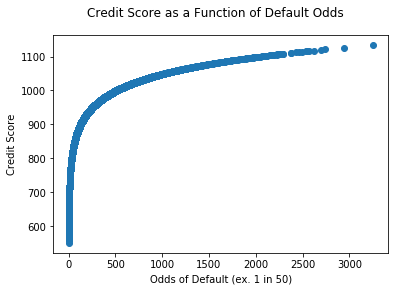

In [98]:
scatter = plt.scatter([1/prob for prob in probs], scores)
y = plt.ylabel('Credit Score')
x = plt.xlabel('Odds of Default (ex. 1 in 50)')
title = plt.suptitle('Credit Score as a Function of Default Odds')

In [29]:
X_train['CREDIT_SCORE'] = scores
X_train.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,DISBURSED_AMOUNT,LTV,PERFORM_CNS_SCORE,IS_FEMALE,RECENCY,FREQUENCY,CREDIT_SCORE
131818,58513,87.80,14,0,1,0.164013,621.443157
75212,63213,59.91,0,0,1,0.048342,833.271657
66296,55844,76.92,0,0,1,0.171508,623.962742
91713,54659,74.72,0,1,0,0.056588,920.702552
166460,49078,88.79,774,1,0,0.023780,989.391061


## 3.3 Visualizing Distribution of Biased Scores for Men & Women

In the following distribution, we see that women's credit scores are distributed significantly lower than men's scores.

Number of Men: 79092, Number of Women: 80908


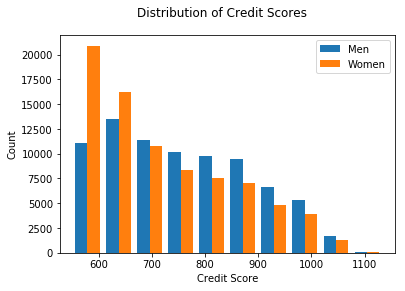

In [30]:
men_scores = X_train[X_train['IS_FEMALE'] == 0]['CREDIT_SCORE'].values
women_scores = X_train[X_train['IS_FEMALE'] == 1]['CREDIT_SCORE'].values
hist = plt.hist([men_scores, women_scores], label=['Men', 'Women'])
y = plt.ylabel('Count')
x = plt.xlabel('Credit Score')
plt.legend(loc='upper right')
title = plt.suptitle('Distribution of Credit Scores')
print(f'Number of Men: {len(men_scores)}, Number of Women: {len(women_scores)}')

# Part 4: Fair Model Building


## 4.1 Train Logistic Regressor Using Fairlearn with Demographic Parity

For our model to be fair (from a regulatory perspective), it must show demographic parity. In other words, our model must predict that men and women default at roughly equal rates. Using Microsoft's Fairlearn library, we encode this condition, and get a set of fair predictions.

In [271]:
log = LogisticRegression(solver='liblinear', max_iter=100, penalty='l1')
res_tuple = red.expgrad(X_train_no_gender, X_train['IS_FEMALE'], y_train, log,
                                cons=moments.DP(), eps=0.007)

In [272]:
res = res_tuple._asdict()
Q = res["best_classifier"]
res["n_classifiers"] = len(res["classifiers"])

disp = moments.EO()
disp.init(X_train_no_gender, X_train['IS_FEMALE'], y_train)

error = moments.MisclassError()
error.init(X_train_no_gender, X_train['IS_FEMALE'], y_train)

res["disp"] = disp.gamma(Q).max()
res["error"] = error.gamma(Q)[0]

print(res['error'])

0.22148234696607785


## 4.2 Calculate Probability Estimates from Fair Model

Now that we have predictions that would be considered 'fair' (ie show Demographic Parity), we train a Logistic Regression Model to learn these fair predictions. 

We'll see that the accuracy of our fair model is about 5% lower than that of the biased model, which is natural; we are essentially performing a form of affirmative action by ensuring that men and women are predicted to default at around the same rate. 

In [273]:
# get fair probabilities
fairProbs = Q(X_train_no_gender)

# convert probabilities to predictions
def probToLabel(prob):
    if prob > 0.5:
        return 1
    else:
        return 0
fairPreds = [probToLabel(prob) for prob in fairProbs]

# train model on fair predictions
fairLog = LogisticRegression(solver='liblinear', max_iter=100, penalty='l1')
fairReg = log.fit(X_train_no_gender, fairPreds)
print(fairReg.coef_)
print(fairReg.intercept_)
fairProbs = [prob[1] for prob in fairReg.predict_proba(X_train_no_gender)]

[[-3.25303115e-05 -1.51859676e-01  7.13606585e-03 -3.06257745e+00
  -3.07930322e+01]]
[0.]


In [274]:
print(f'Train accuracy: {fairReg.score(X_train_no_gender, y_train)}, Test accuracy: {fairReg.score(X_test_no_gender, y_test)}')
print(f'Train f1: {f1_score(y_train, fairReg.predict(X_train_no_gender))}, Test f1: {f1_score(y_test, fairReg.predict(X_test_no_gender))}')

Train accuracy: 0.78464375, Test accuracy: 0.785225
Train f1: 0.0, Test f1: 0.0


## 4.3 Convert Probability Estimates to Fair Credit Scores

With our fair probabilities in hand, we can generate credit scores in the same way we did from our biased probability estimates. 

In [275]:
fairScores = [scoreFromOdds(1/prob) for prob in fairProbs]
X_train['FAIR_CREDIT_SCORE'] = fairScores
X_train.head(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DISBURSED_AMOUNT,LTV,PERFORM_CNS_SCORE,IS_FEMALE,RECENCY,FREQUENCY,CREDIT_SCORE,FAIR_CREDIT_SCORE
131818,58513,87.80,14,0,1,0.164013,621.443157,2227.122806
75212,63213,59.91,0,0,1,0.048342,833.271657,1682.907428
66296,55844,76.92,0,0,1,0.171508,623.962742,2125.531692
91713,54659,74.72,0,1,0,0.056588,920.702552,1622.466608
166460,49078,88.79,774,1,0,0.023780,989.391061,1292.203018
181517,46145,66.66,0,0,1,0.020277,884.084203,1654.458490
7459,33529,60.23,300,1,0,0.223133,681.909916,1629.665180
136279,48803,68.69,300,1,1,0.235925,580.770086,2007.513540
141733,72817,73.60,749,1,0,0.092419,873.214619,1346.842658
105038,73317,66.03,651,1,0,0.192974,708.798103,1538.894864


## 4.4 Compare Score Distributions For Fair vs. Unfair Model

Here, we show a side by side comparison of the biased model with our fair model. Two takeaways:

(1) The fair model clearly corrects for biases; men and women show much more similar distributions of scores.
(2) In the fair model, people are predicted to default much less often. This is a common issue in using Demographic Parity; a simple way to ensure demographic parity is to assume everyone either defaults or doesn't default.

Number of Men: 79092, Number of Women: 80908


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(500, 2600)

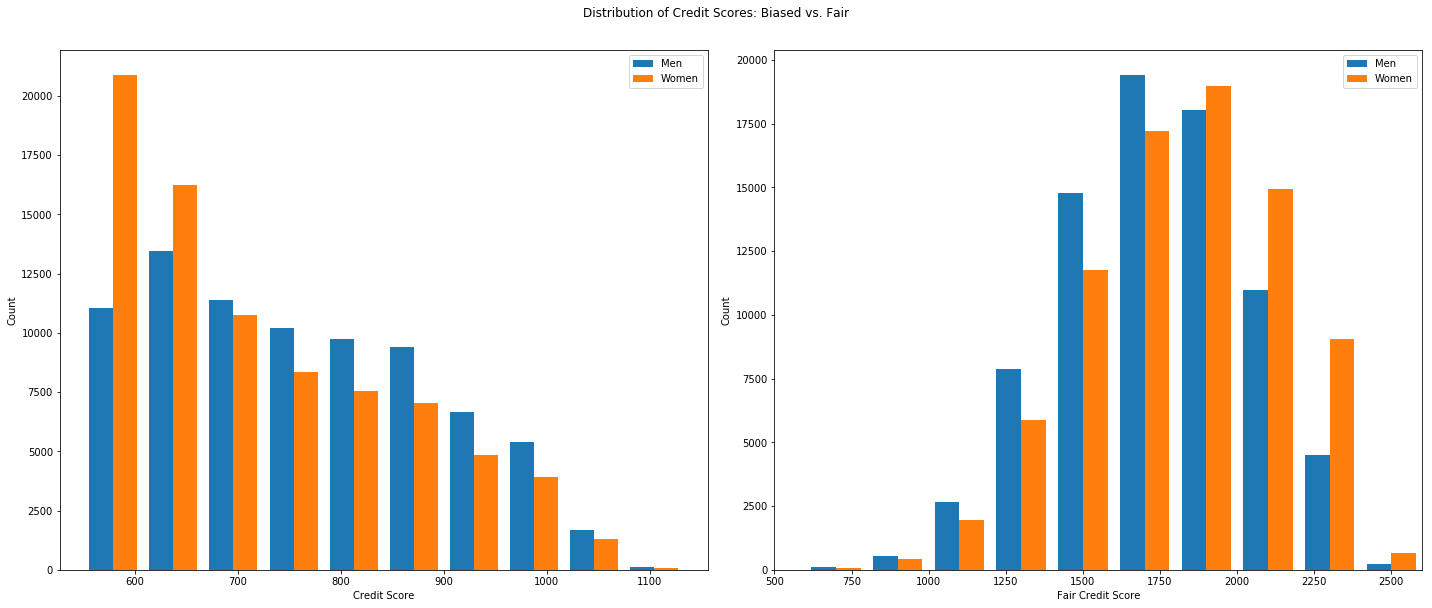

In [278]:
X_train['CREDIT_SCORE'] = scores
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)

men_scores = X_train[X_train['IS_FEMALE'] == 0]['CREDIT_SCORE'].values
women_scores = X_train[X_train['IS_FEMALE'] == 1]['CREDIT_SCORE'].values
hist = plt.hist([men_scores, women_scores], label=['Men', 'Women'])
y = plt.ylabel('Count')
x = plt.xlabel('Credit Score')
plt.legend(loc='upper right')
# title = plt.suptitle('Distribution of Credit Scores')

plt.subplot(1, 2, 2)

men_scores_fair = X_train[X_train['IS_FEMALE'] == 0]['FAIR_CREDIT_SCORE'].values
women_scores_fair = X_train[X_train['IS_FEMALE'] == 1]['FAIR_CREDIT_SCORE'].values
fairHist = plt.hist([men_scores_fair, women_scores_fair], label=['Men', 'Women'], bins=range(0, 3000, 200))
y = plt.ylabel('Count')
x = plt.xlabel('Fair Credit Score')
plt.legend(loc='upper right')
title = plt.suptitle('Distribution of Credit Scores: Biased vs. Fair')
title.set_position([.5, 1.05])
print(f'Number of Men: {len(men_scores)}, Number of Women: {len(women_scores)}')
plt.tight_layout()
plt.xlim(500, 2600)

# Part 5: Analyzing the Fairness of our Models via Matched pairs Analysis

One technique we will employ to determine the fairness of each model is _matched pairs analysis_.

In our matched pairs analysis, for each woman, we find the closest man in terms of the other predictors used in our model (ex. recency and frequency of late payments). We then note the credit scores assigned to the woman and her closest male counterpart, and measure the difference between the two. If the difference is small, we can conclude that we are treating similar individuals similarly (regardless of gender). If not, then the model shows bias!

## 5.1 Write Function for Matched Pairs Analysis

Here, we used 1-Nearest-Neighbors to get the closest male counterpart of each female, and return an array of the difference in either the biased credit score (offset=2) or the fair credit score (offset=1).

In [ ]:
def getMatchingPairsDiff(men, women, full, offset=1, scaler=True):
    men_x = men.values
    women_x = women.values
    if scaler == True:
        scaler = StandardScaler()
    if scaler:
        scaler.fit(men_x)
        men_x = scaler.transform(men_x)
        women_x = scaler.transform(women_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(men_x)
    distances, indices = nbrs.kneighbors(women_x)
    indices = indices.reshape(indices.shape[0])
    diffs = []
    rows, cols = women.shape
    for i in range(rows):
        if i < 10:
            print(f'index: {i}, Woman Score is: {women.iloc[i, cols-offset]}, Man Score is: {men.iloc[indices[i], cols-offset]}, Diff: {women.iloc[i, cols-offset] - men.iloc[indices[i], cols-offset]}')
        diffs.append(women.iloc[i, cols-offset] - men.iloc[indices[i], cols-offset])
    return diffs

## 5.2 Compare Matched Pairs Analysis for Both Models

Here, we display the distribution of score differences of each matched pair. Note that the biased model actually passes matched pairs analysis, because we do treat a man and woman, all else equal, the same. 

The issue lies in women and men, on average, displaying different behaviors, with some of the behaviors women are correlated resulting in their having lower credit scores. For example, being female (in our model) is correlated with making late payments a higher percentage of the time, reducing their credit scores.

In [ ]:
# Unfair Model
men = X_train[X_train['IS_FEMALE'] == 0]
women = X_train[X_train['IS_FEMALE'] == 1]
diffs = getMatchingPairsDiff(men, women, X_train, offset=2)
diffplot = plt.plot(diffs)
y = plt.ylabel('Count')
x = plt.xlabel('Difference in Credit Score')
title = plt.suptitle('Difference in Credit Score Between Matched Pairs: Biased Model')

In [ ]:
print('\n---------------------------------------------------Biased Model---------------------------------------------------\n')
average = sum(scores)/len(scores)
print(f'Mean Score: {average}, Mean Normalized Diff: {(sum(diffs)/len(diffs))/average*100}, Mean Normalized Absolute Diff: {(sum([abs(diff) for diff in diffs])/len(diffs))/average * 100}')
print(f'Men Number of Predicted Defaults:{men[men.CREDIT_SCORE < 600].count()[0]}, Women Number of Predicted Defaults:{women[women.CREDIT_SCORE < 600].count()[0]}')



In [ ]:
# Fair Model
diffs = getMatchingPairsDiff(men, women, X_train, offset=1)
diffplot = plt.hist(diffs)
y = plt.ylabel('Count')
x = plt.xlabel('Difference in Credit Score')
title = plt.suptitle('Difference in Credit Score Between Matched Pairs: Fair Model')

In [ ]:
average = sum(fairScores)/len(fairScores)
print(f'Mean Score: {average}, Mean Normalized Diff: {(sum(diffs)/len(diffs))/average*100}, Mean Normalized Absolute Diff: {(sum([abs(diff) for diff in diffs])/len(diffs))/average * 100}')
print(f'Men Number of Predicted Defaults:{men[men.FAIR_CREDIT_SCORE < 600].count()[0]}, Women Number of Predicted Defaults:{women[women.FAIR_CREDIT_SCORE < 600].count()[0]}')



## Part 6: A New Fairness Library (AIF360)

We tried a different fairness library earlier in the project created by IBM. For anyone interested, our process is documented below. The resulting model predicted a single class.

In [44]:
# import sys
# sys.path.append("../")
# import numpy as np

In [45]:
# from aif360.datasets import BinaryLabelDataset, StandardDataset
# from aif360.metrics import BinaryLabelDatasetMetric
# from aif360.metrics import ClassificationMetric
# from aif360.algorithms.preprocessing.reweighing import Reweighing
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score
# from tqdm import tqdm
# from collections import OrderedDict
# from aif360.metrics import ClassificationMetric


In [46]:
# dataset_orig = StandardDataset(df=train_x, label_name='LOAN_DEFAULT',  favorable_classes=[0], protected_attribute_names=['IS_FEMALE'], privileged_classes=[lambda x: x == 1])

# dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
# dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [47]:
# metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
#                                              unprivileged_groups=unprivileged_groups,
#                                              privileged_groups=privileged_groups)
# print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

In [48]:
# RW = Reweighing(unprivileged_groups=unprivileged_groups,
#                privileged_groups=privileged_groups)
# RW.fit(dataset_orig_train)
# dataset_transf_train = RW.transform(dataset_orig_train)

In [49]:
# metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
#                                          unprivileged_groups=unprivileged_groups,
#                                          privileged_groups=privileged_groups)
# print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

In [50]:
# scale_orig = StandardScaler()
# X_train = scale_orig.fit_transform(dataset_orig_train.features)
# y_train = dataset_orig_train.labels.ravel()
# w_train = dataset_orig_train.instance_weights.ravel()

# lmod = LogisticRegression(solver='lbfgs')
# lmod.fit(X_train, y_train, 
#          sample_weight=dataset_orig_train.instance_weights)
# y_train_pred = lmod.predict(X_train)

# # positive class index
# pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

# dataset_orig_train_pred = dataset_orig_train.copy()
# dataset_orig_train_pred.labels = y_train_pred

In [51]:
# dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
# X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
# y_valid = dataset_orig_valid_pred.labels
# dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

# dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
# X_test = scale_orig.transform(dataset_orig_test_pred.features)
# y_test = dataset_orig_test_pred.labels
# dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [52]:
# probs = [prob[1] for prob in lmod.predict_proba(X_train)]
# scores = [scoreFromOdds(1/prob) for prob in probs]

# X_train['CREDIT_SCORE'] = scores

# men_scores = X_train[X_train['IS_FEMALE'] == 0]['CREDIT_SCORE'].values
# women_scores = X_train[X_train['IS_FEMALE'] == 1]['CREDIT_SCORE'].values
# hist = plt.hist([men_scores, women_scores], label=['Men', 'Women'])
# y = plt.ylabel('Count')
# x = plt.xlabel('Credit Score')
# plt.legend(loc='upper right')
# title = plt.suptitle('Distribution of Credit Scores')
# print(f'Number of Men: {len(men_scores)}, Number of Women: {len(women_scores)}')


In [53]:
# num_thresh = 100
# ba_arr = np.zeros(num_thresh)
# class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
# for idx, class_thresh in enumerate(class_thresh_arr):
    
#     fav_inds = dataset_orig_valid_pred.scores > class_thresh
#     dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
#     dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
#     classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
#                                              dataset_orig_valid_pred, 
#                                              unprivileged_groups=unprivileged_groups,
#                                              privileged_groups=privileged_groups)
    
#     ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
#                        +classified_metric_orig_valid.true_negative_rate())

# best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
# best_class_thresh = class_thresh_arr[best_ind]

# print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
# print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

In [54]:
# def compute_metrics(dataset_true, dataset_pred, 
#                     unprivileged_groups, privileged_groups,
#                     disp = True):
#     """ Compute the key metrics """
#     classified_metric_pred = ClassificationMetric(dataset_true,
#                                                  dataset_pred, 
#                                                  unprivileged_groups=unprivileged_groups,
#                                                  privileged_groups=privileged_groups)
#     metrics = OrderedDict()
#     metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
#                                              classified_metric_pred.true_negative_rate())
#     metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
#     metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
#     metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
#     metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
#     metrics["Theil index"] = classified_metric_pred.theil_index()
    
#     if disp:
#         for k in metrics:
#             print("%s = %.4f" % (k, metrics[k]))
    
#     return metrics

In [55]:
# print("#### Predictions from original testing data")
# bal_acc_arr_orig = []
# disp_imp_arr_orig = []
# avg_odds_diff_arr_orig = []

# print("Classification threshold used = %.4f" % best_class_thresh)
# for thresh in tqdm(class_thresh_arr):
    
#     if thresh == best_class_thresh:
#         disp = True
#     else:
#         disp = False
    
#     fav_inds = dataset_orig_test_pred.scores > thresh
#     dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
#     dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
#     metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
#                                       unprivileged_groups, privileged_groups,
#                                       disp = disp)

#     bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
#     avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
#     disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

In [56]:
# scale_transf = StandardScaler()
# X_train = scale_transf.fit_transform(dataset_transf_train.features)
# y_train = dataset_transf_train.labels.ravel()

# lmod = LogisticRegression(solver='lbfgs')
# lmod.fit(X_train, y_train,
#         sample_weight=dataset_transf_train.instance_weights)
# y_train_pred = lmod.predict(X_train)

In [57]:
# dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
# X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
# y_test = dataset_transf_test_pred.labels
# dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [58]:
# print("#### Predictions from transformed testing data")
# bal_acc_arr_transf = []
# disp_imp_arr_transf = []
# avg_odds_diff_arr_transf = []

# print("Classification threshold used = %.4f" % best_class_thresh)
# for thresh in tqdm(class_thresh_arr):
    
#     if thresh == best_class_thresh:
#         disp = True
#     else:
#         disp = False
    
#     fav_inds = dataset_transf_test_pred.scores > thresh
#     dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
#     dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
#     metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
#                                       unprivileged_groups, privileged_groups,
#                                       disp = disp)

#     bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
#     avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
#     disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])